# 探索 RoboMind Failure Data - HDF5 文件结构

本notebook用于分析 `/projects/p32958/chengxuan/data/robomind_fail/failure_data/135-place_cup_on_blue_bowl_with_left_hand/夹取前碰撞/1135137-2025_03_05_16_57_11/data/trajectory.hdf5` 的内部数据结构

In [3]:
import h5py
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Dict, List

In [4]:
# HDF5文件路径
h5_path = "/projects/p32958/chengxuan/data/robomind_fail/failure_data/135-place_cup_on_blue_bowl_with_left_hand/夹取前碰撞/1135137-2025_03_05_16_57_11/data/trajectory.hdf5"

print(f"🔍 分析文件: {h5_path}")
print(f"文件是否存在: {Path(h5_path).exists()}")
if Path(h5_path).exists():
    file_size_mb = Path(h5_path).stat().st_size / 1024 / 1024
    print(f"文件大小: {file_size_mb:.2f} MB")

🔍 分析文件: /projects/p32958/chengxuan/data/robomind_fail/failure_data/135-place_cup_on_blue_bowl_with_left_hand/夹取前碰撞/1135137-2025_03_05_16_57_11/data/trajectory.hdf5
文件是否存在: True
文件大小: 74.75 MB


## 1. 探索HDF5文件整体结构

In [5]:
def explore_h5_structure(path, max_depth=5):
    """递归探索HDF5文件结构"""
    
    def print_structure(name, obj, depth=0):
        if depth > max_depth:
            return
        
        indent = "  " * depth
        
        if isinstance(obj, h5py.Group):
            print(f"{indent}📁 {name}/ (Group)")
            # 打印属性
            if obj.attrs:
                for key, val in obj.attrs.items():
                    print(f"{indent}   @{key} = {val}")
        
        elif isinstance(obj, h5py.Dataset):
            print(f"{indent}📄 {name} (Dataset)")
            print(f"{indent}   Shape: {obj.shape}")
            print(f"{indent}   Dtype: {obj.dtype}")
            
            # 如果是小数据集，显示前几个值
            if obj.size < 10 and obj.size > 0:
                try:
                    print(f"{indent}   Values: {obj[...]}")
                except:
                    pass
            
            # 打印属性
            if obj.attrs:
                for key, val in obj.attrs.items():
                    print(f"{indent}   @{key} = {val}")
    
    print(f"\n{'='*80}")
    print(f"🔍 HDF5文件完整结构")
    print(f"{'='*80}\n")
    
    with h5py.File(path, 'r') as f:
        # 打印文件级别属性
        print("📋 文件级别属性:")
        if f.attrs:
            for key, val in f.attrs.items():
                print(f"  @{key} = {val}")
        else:
            print("  (无文件属性)")
        print()
        
        # 打印顶层keys
        print("📂 顶层结构:")
        print(f"  Keys: {list(f.keys())}")
        print()
        
        # 递归打印结构
        print("📊 详细结构:")
        f.visititems(print_structure)

# 运行探索
explore_h5_structure(h5_path)


🔍 HDF5文件完整结构

📋 文件级别属性:
  @compress = True
  @sim = True

📂 顶层结构:
  Keys: ['language_instruction', 'observations', 'sim_time_seq', 'tiangong']

📊 详细结构:
📄 language_instruction (Dataset)
   Shape: ()
   Dtype: object
   Values: b'place_cup_on_blue_bowl_with_left_hand'
📁 observations/ (Group)
📁 observations/depth_images/ (Group)
📄 observations/depth_images/camera_chest (Dataset)
   Shape: (903,)
   Dtype: object
📄 observations/depth_images/camera_head (Dataset)
   Shape: (903,)
   Dtype: object
📁 observations/rgb_images/ (Group)
📄 observations/rgb_images/camera_chest (Dataset)
   Shape: (865,)
   Dtype: object
📄 observations/rgb_images/camera_head (Dataset)
   Shape: (865,)
   Dtype: object
📄 sim_time_seq (Dataset)
   Shape: (865,)
   Dtype: float64
📁 tiangong/ (Group)
📄 tiangong/left_arm_joint_effort_seqs (Dataset)
   Shape: (923, 7)
   Dtype: float64
📄 tiangong/left_arm_joint_pos_seq (Dataset)
   Shape: (922, 7)
   Dtype: float64
📄 tiangong/left_arm_joint_vel_seq (Dataset)
   Shape: (9

## 2. 检查常见数据路径

In [6]:
def check_common_paths(path):
    """检查常见的数据路径"""
    
    print(f"\n{'='*80}")
    print("🎯 检查常见数据路径")
    print(f"{'='*80}\n")
    
    # 常见路径列表
    paths_to_check = [
        # 观测数据
        'observations',
        'observations/rgb_images',
        'observations/images',
        'observations/depth',
        'observations/state',
        'observations/proprio',
        'obs',
        'obs/rgb_images',
        
        # 图像数据
        'rgb_images',
        'images',
        'camera',
        'camera_images',
        
        # 动作数据
        'actions',
        'action',
        
        # 状态数据
        'states',
        'state',
        
        # 奖励/终止
        'rewards',
        'reward',
        'dones',
        'done',
        'terminals',
        
        # 元数据
        'metadata',
        'info',
    ]
    
    with h5py.File(path, 'r') as f:
        found_paths = []
        missing_paths = []
        
        for path_str in paths_to_check:
            if path_str in f:
                found_paths.append(path_str)
                obj = f[path_str]
                
                print(f"✅ {path_str}")
                
                if isinstance(obj, h5py.Group):
                    keys = list(obj.keys())
                    print(f"   类型: Group")
                    print(f"   子项数量: {len(keys)}")
                    if len(keys) <= 10:
                        print(f"   子项列表: {keys}")
                    else:
                        print(f"   子项列表(前10): {keys[:10]}...")
                    
                    # 如果是图像组，显示每个相机的信息
                    if 'image' in path_str.lower() or 'camera' in path_str.lower():
                        for camera_name in keys[:5]:  # 只显示前5个
                            camera_data = obj[camera_name]
                            if isinstance(camera_data, h5py.Dataset):
                                print(f"     - {camera_name}: shape={camera_data.shape}, dtype={camera_data.dtype}")
                
                elif isinstance(obj, h5py.Dataset):
                    print(f"   类型: Dataset")
                    print(f"   Shape: {obj.shape}")
                    print(f"   Dtype: {obj.dtype}")
                    
                    # 显示数据范围
                    if obj.size > 0 and obj.dtype.kind in ['i', 'f', 'u']:
                        try:
                            data_sample = obj[0] if len(obj.shape) > 0 else obj[...]
                            print(f"   首个元素: {data_sample}")
                        except:
                            pass
                
                # 打印属性
                if obj.attrs:
                    print(f"   属性: {dict(obj.attrs)}")
                
                print()
            else:
                missing_paths.append(path_str)
        
        print(f"\n📊 统计: 找到 {len(found_paths)}/{len(paths_to_check)} 个路径")

# 检查常见路径
check_common_paths(h5_path)


🎯 检查常见数据路径

✅ observations
   类型: Group
   子项数量: 2
   子项列表: ['depth_images', 'rgb_images']

✅ observations/rgb_images
   类型: Group
   子项数量: 2
   子项列表: ['camera_chest', 'camera_head']
     - camera_chest: shape=(865,), dtype=object
     - camera_head: shape=(865,), dtype=object


📊 统计: 找到 2/23 个路径


## 3. 分析图像数据

In [7]:
def analyze_image_data(path):
    """详细分析图像数据"""
    
    print(f"\n{'='*80}")
    print("🖼️ 图像数据详细分析")
    print(f"{'='*80}\n")
    
    with h5py.File(path, 'r') as f:
        # 检查是否压缩
        is_compress = f.attrs.get('compress', False)
        print(f"压缩状态: {is_compress}\n")
        
        # 寻找图像数据
        image_paths = []
        
        def find_images(name, obj):
            if isinstance(obj, h5py.Dataset):
                # 检查是否可能是图像数据
                if ('image' in name.lower() or 'camera' in name.lower() or 
                    'rgb' in name.lower() or 'depth' in name.lower()):
                    image_paths.append(name)
        
        f.visititems(find_images)
        
        if image_paths:
            print(f"找到 {len(image_paths)} 个可能的图像数据集:\n")
            
            for img_path in image_paths:
                img_data = f[img_path]
                print(f"📷 {img_path}")
                print(f"   Shape: {img_data.shape}")
                print(f"   Dtype: {img_data.dtype}")
                print(f"   Size: {img_data.size} elements")
                print(f"   Memory: {img_data.nbytes / 1024 / 1024:.2f} MB")
                
                # 分析shape含义
                if len(img_data.shape) >= 2:
                    print(f"   可能的解释:")
                    if len(img_data.shape) == 1:
                        print(f"     - 压缩图像数据 (需要解码)")
                    elif len(img_data.shape) == 2:
                        print(f"     - {img_data.shape[0]} 帧压缩图像")
                        print(f"     - 或 {img_data.shape[0]}x{img_data.shape[1]} 灰度图像")
                    elif len(img_data.shape) == 3:
                        if img_data.shape[-1] in [1, 3, 4]:
                            print(f"     - 单帧图像: {img_data.shape[0]}x{img_data.shape[1]}, {img_data.shape[2]} 通道")
                        else:
                            print(f"     - {img_data.shape[0]} 帧, {img_data.shape[1]}x{img_data.shape[2]} 图像")
                    elif len(img_data.shape) == 4:
                        print(f"     - {img_data.shape[0]} 帧")
                        print(f"     - 分辨率: {img_data.shape[1]}x{img_data.shape[2]}")
                        print(f"     - 通道数: {img_data.shape[3]}")
                
                print()
        else:
            print("❌ 未找到图像数据")

# 分析图像数据
analyze_image_data(h5_path)


🖼️ 图像数据详细分析

压缩状态: True

找到 4 个可能的图像数据集:

📷 observations/depth_images/camera_chest
   Shape: (903,)
   Dtype: object
   Size: 903 elements
   Memory: 0.01 MB

📷 observations/depth_images/camera_head
   Shape: (903,)
   Dtype: object
   Size: 903 elements
   Memory: 0.01 MB

📷 observations/rgb_images/camera_chest
   Shape: (865,)
   Dtype: object
   Size: 865 elements
   Memory: 0.01 MB

📷 observations/rgb_images/camera_head
   Shape: (865,)
   Dtype: object
   Size: 865 elements
   Memory: 0.01 MB



## 4. 分析动作和状态数据

In [8]:
def analyze_action_state_data(path):
    """分析动作和状态数据"""
    
    print(f"\n{'='*80}")
    print("🎮 动作和状态数据分析")
    print(f"{'='*80}\n")
    
    with h5py.File(path, 'r') as f:
        # 查找动作数据
        action_paths = ['actions', 'action', 'act']
        state_paths = ['states', 'state', 'observations/state', 'observations/proprio']
        
        print("🎯 动作数据:")
        found_action = False
        for action_path in action_paths:
            if action_path in f:
                found_action = True
                action_data = f[action_path]
                print(f"\n  路径: {action_path}")
                print(f"  Shape: {action_data.shape}")
                print(f"  Dtype: {action_data.dtype}")
                
                if len(action_data.shape) == 2:
                    print(f"  时间步数: {action_data.shape[0]}")
                    print(f"  动作维度: {action_data.shape[1]}")
                    
                    # 显示统计信息
                    if action_data.dtype.kind in ['f', 'i', 'u']:
                        print(f"  数值范围:")
                        print(f"    Min: {np.min(action_data[...], axis=0)}")
                        print(f"    Max: {np.max(action_data[...], axis=0)}")
                        print(f"    Mean: {np.mean(action_data[...], axis=0)}")
                        print(f"  前3个时间步的动作:")
                        print(action_data[:3])
        
        if not found_action:
            print("  ❌ 未找到动作数据\n")
        
        print("\n📊 状态数据:")
        found_state = False
        for state_path in state_paths:
            if state_path in f:
                found_state = True
                state_data = f[state_path]
                print(f"\n  路径: {state_path}")
                
                if isinstance(state_data, h5py.Group):
                    print(f"  类型: Group")
                    print(f"  包含的状态: {list(state_data.keys())}")
                    for key in state_data.keys():
                        sub_data = state_data[key]
                        if isinstance(sub_data, h5py.Dataset):
                            print(f"    - {key}: shape={sub_data.shape}, dtype={sub_data.dtype}")
                else:
                    print(f"  Shape: {state_data.shape}")
                    print(f"  Dtype: {state_data.dtype}")
                    
                    if len(state_data.shape) == 2:
                        print(f"  时间步数: {state_data.shape[0]}")
                        print(f"  状态维度: {state_data.shape[1]}")
                        print(f"  前3个时间步的状态:")
                        print(state_data[:3])
        
        if not found_state:
            print("  ❌ 未找到状态数据")

# 分析动作和状态数据
analyze_action_state_data(h5_path)


🎮 动作和状态数据分析

🎯 动作数据:
  ❌ 未找到动作数据


📊 状态数据:
  ❌ 未找到状态数据


## 5. 提取并可视化示例图像


🎨 图像可视化


📷 可视化: observations/rgb_images
   找到 2 个相机: ['camera_chest', 'camera_head']

   相机: camera_chest, 总帧数: 865


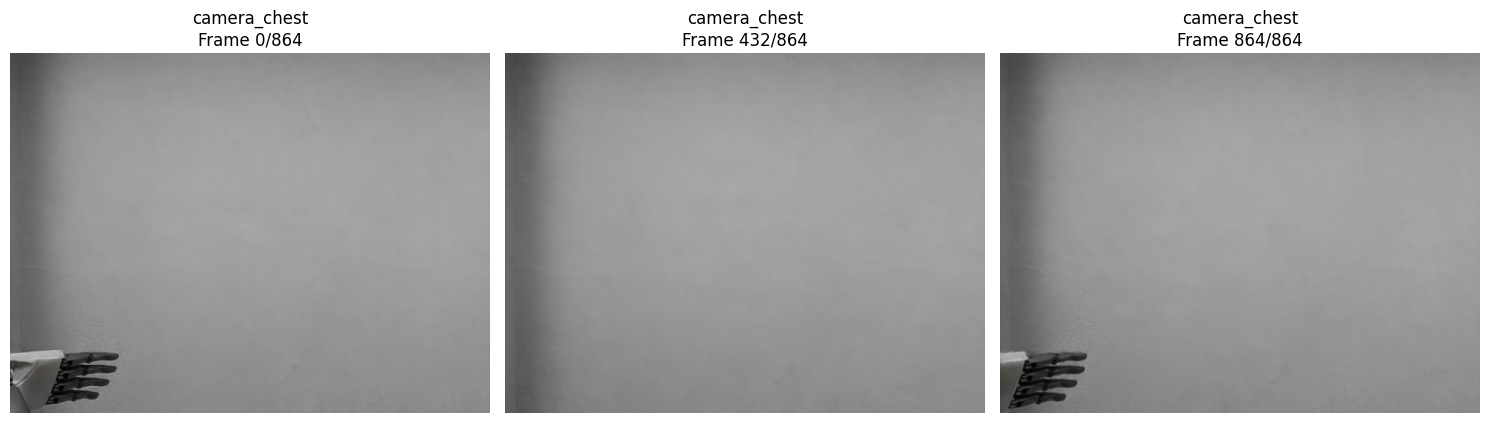

   相机: camera_head, 总帧数: 865


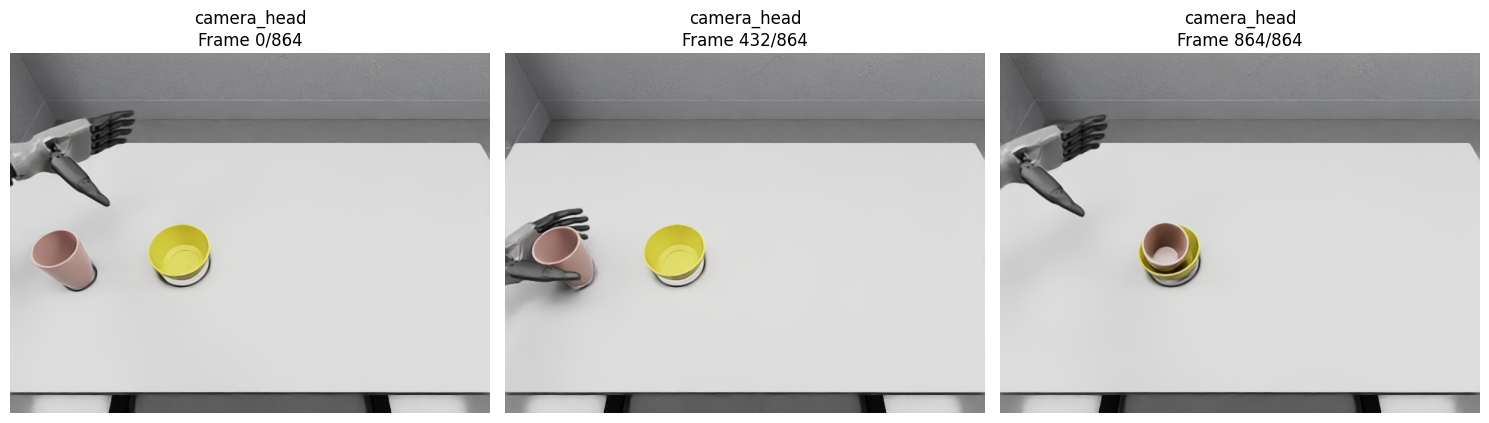

In [9]:
def decode_image(compressed_image: np.ndarray) -> np.ndarray:
    """解码压缩的图像数据"""
    if compressed_image is None:
        return None
    
    # 如果是单个图像
    if len(compressed_image.shape) == 1:
        rgb = cv2.imdecode(compressed_image, cv2.IMREAD_COLOR)
        if rgb is None:
            # 尝试直接解析为数组
            rgb = np.frombuffer(compressed_image, dtype=np.uint8)
            # 根据大小判断图像尺寸
            if rgb.size == 2764800:  # 720 * 1280 * 3
                rgb = rgb.reshape(720, 1280, 3)
            elif rgb.size == 921600:  # 480 * 640 * 3
                rgb = rgb.reshape(480, 640, 3)
            elif rgb.size == 307200:  # 480 * 640
                rgb = rgb.reshape(480, 640)
        if rgb is not None and len(rgb.shape) == 3:
            rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        return rgb
    else:
        return None

def visualize_images(path, num_frames=3):
    """提取并可视化图像"""
    
    print(f"\n{'='*80}")
    print("🎨 图像可视化")
    print(f"{'='*80}\n")
    
    with h5py.File(path, 'r') as f:
        # 查找图像数据
        image_groups = []
        
        # 检查常见路径
        if 'observations/rgb_images' in f:
            image_groups.append(('observations/rgb_images', f['observations/rgb_images']))
        elif 'rgb_images' in f:
            image_groups.append(('rgb_images', f['rgb_images']))
        elif 'images' in f:
            image_groups.append(('images', f['images']))
        
        if not image_groups:
            print("❌ 未找到可视化的图像数据")
            return
        
        is_compress = f.attrs.get('compress', True)
        
        for group_name, image_group in image_groups:
            print(f"\n📷 可视化: {group_name}")
            
            if isinstance(image_group, h5py.Group):
                cameras = list(image_group.keys())
                print(f"   找到 {len(cameras)} 个相机: {cameras}\n")
                
                # 为每个相机可视化
                for camera_name in cameras[:3]:  # 最多显示3个相机
                    camera_data = image_group[camera_name]
                    total_frames = camera_data.shape[0]
                    
                    print(f"   相机: {camera_name}, 总帧数: {total_frames}")
                    
                    # 选择要显示的帧索引
                    if total_frames <= num_frames:
                        frame_indices = list(range(total_frames))
                    else:
                        # 均匀采样
                        frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
                    
                    # 创建图像显示
                    fig, axes = plt.subplots(1, len(frame_indices), figsize=(5*len(frame_indices), 5))
                    if len(frame_indices) == 1:
                        axes = [axes]
                    
                    for idx, frame_idx in enumerate(frame_indices):
                        # 读取图像
                        if is_compress:
                            img = decode_image(camera_data[frame_idx])
                        else:
                            img = camera_data[frame_idx]
                        
                        if img is not None:
                            axes[idx].imshow(img)
                            axes[idx].set_title(f"{camera_name}\nFrame {frame_idx}/{total_frames-1}")
                            axes[idx].axis('off')
                        else:
                            axes[idx].text(0.5, 0.5, 'Failed to decode', 
                                         ha='center', va='center')
                            axes[idx].set_title(f"Frame {frame_idx} (decode failed)")
                    
                    plt.tight_layout()
                    plt.show()
            
            elif isinstance(image_group, h5py.Dataset):
                # 直接是数据集
                total_frames = image_group.shape[0]
                print(f"   总帧数: {total_frames}\n")
                
                # 选择要显示的帧索引
                if total_frames <= num_frames:
                    frame_indices = list(range(total_frames))
                else:
                    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
                
                # 创建图像显示
                fig, axes = plt.subplots(1, len(frame_indices), figsize=(5*len(frame_indices), 5))
                if len(frame_indices) == 1:
                    axes = [axes]
                
                for idx, frame_idx in enumerate(frame_indices):
                    if is_compress:
                        img = decode_image(image_group[frame_idx])
                    else:
                        img = image_group[frame_idx]
                    
                    if img is not None:
                        axes[idx].imshow(img)
                        axes[idx].set_title(f"Frame {frame_idx}/{total_frames-1}")
                        axes[idx].axis('off')
                
                plt.tight_layout()
                plt.show()

# 可视化图像
visualize_images(h5_path, num_frames=3)

## 6. 生成完整数据摘要

In [10]:
def generate_summary(path):
    """生成数据集的完整摘要"""
    
    print(f"\n{'='*80}")
    print("📋 完整数据摘要")
    print(f"{'='*80}\n")
    
    with h5py.File(path, 'r') as f:
        summary = {
            'file_attrs': dict(f.attrs),
            'top_level_keys': list(f.keys()),
            'data_types': {}
        }
        
        # 收集所有数据集信息
        def collect_info(name, obj):
            if isinstance(obj, h5py.Dataset):
                summary['data_types'][name] = {
                    'shape': obj.shape,
                    'dtype': str(obj.dtype),
                    'size_mb': obj.nbytes / 1024 / 1024
                }
        
        f.visititems(collect_info)
        
        # 打印摘要
        print("📁 文件属性:")
        for key, val in summary['file_attrs'].items():
            print(f"  {key}: {val}")
        
        print(f"\n📂 顶层结构: {summary['top_level_keys']}")
        
        print(f"\n📊 数据集统计 (共 {len(summary['data_types'])} 个):")
        print(f"\n{'路径':<50} {'Shape':<25} {'类型':<15} {'大小(MB)':>10}")
        print("-" * 100)
        
        total_size = 0
        for name, info in sorted(summary['data_types'].items()):
            shape_str = str(info['shape'])
            print(f"{name:<50} {shape_str:<25} {info['dtype']:<15} {info['size_mb']:>10.2f}")
            total_size += info['size_mb']
        
        print("-" * 100)
        print(f"{'总计':<90} {total_size:>10.2f}")
        
        return summary

# 生成摘要
summary = generate_summary(h5_path)


📋 完整数据摘要

📁 文件属性:
  compress: True
  sim: True

📂 顶层结构: ['language_instruction', 'observations', 'sim_time_seq', 'tiangong']

📊 数据集统计 (共 19 个):

路径                                                 Shape                     类型                  大小(MB)
----------------------------------------------------------------------------------------------------
language_instruction                               ()                        object                0.00
observations/depth_images/camera_chest             (903,)                    object                0.01
observations/depth_images/camera_head              (903,)                    object                0.01
observations/rgb_images/camera_chest               (865,)                    object                0.01
observations/rgb_images/camera_head                (865,)                    object                0.01
sim_time_seq                                       (865,)                    float64               0.01
tiangong/left_arm_joint_e

## 7. 导出数据摘要到JSON

In [11]:
import json

# 导出摘要到JSON文件
output_json = Path(h5_path).parent / "trajectory_summary.json"

# 转换numpy类型为Python原生类型
def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

summary_serializable = json.loads(
    json.dumps(summary, default=convert_to_serializable)
)

with open(output_json, 'w', encoding='utf-8') as f:
    json.dump(summary_serializable, f, indent=2, ensure_ascii=False)

print(f"\n✅ 摘要已保存到: {output_json}")

ValueError: Circular reference detected